In [2]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

train_dir = 'archive/train/'
test_dir = 'archive/test/'

target_var = os.listdir(train_dir)
print(target_var)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


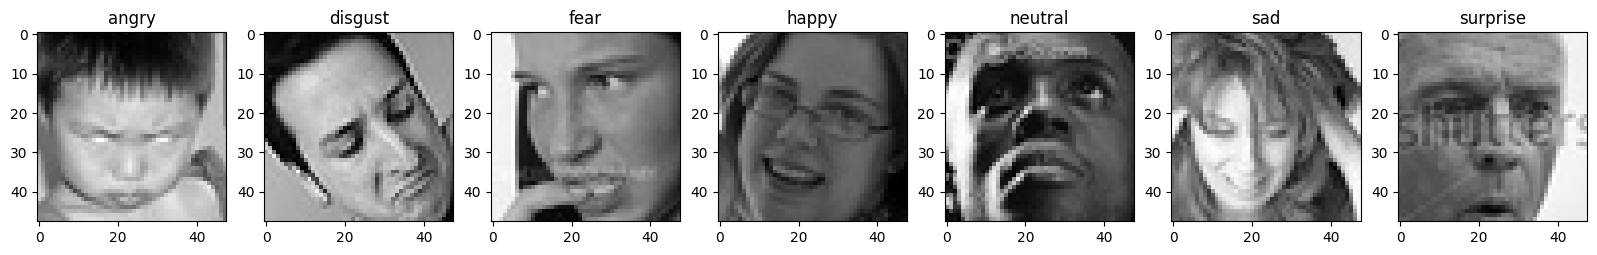

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(1, 7, figsize=(20,8))
for i in range(len(target_var)):
    img_path = os.path.join(train_dir, target_var[i], os.listdir(os.path.join(train_dir, target_var[i]))[0])
    img = Image.open(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(target_var[i])
plt.show()

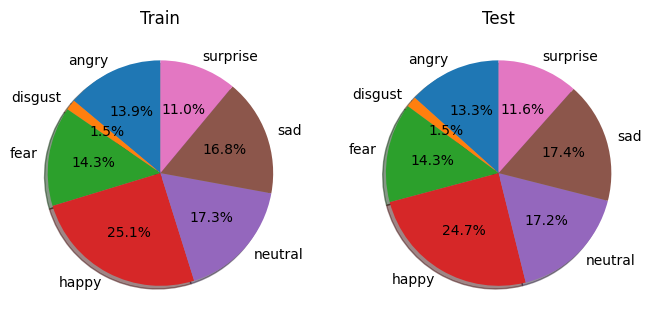

Emotion : angry
	Training : 3995
	Testing : 958
Emotion : disgust
	Training : 436
	Testing : 111
Emotion : fear
	Training : 4097
	Testing : 1024
Emotion : happy
	Training : 7215
	Testing : 1774
Emotion : neutral
	Training : 4965
	Testing : 1233
Emotion : sad
	Training : 4830
	Testing : 1247
Emotion : surprise
	Training : 3171
	Testing : 831


In [5]:
x_train = np.array([len(os.listdir(os.path.join(train_dir, i))) for i in target_var])
x_test = np.array([len(os.listdir(os.path.join(test_dir, i))) for i in target_var])
label = target_var

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

for i in target_var:
    print('Emotion : ' + i)
    print('\tTraining : ' + str(len(os.listdir(os.path.join(train_dir, i)))) + '\n\tTesting : ' + str(len(os.listdir(os.path.join(test_dir, i)))))

In [6]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((48, 48)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Split train dataset into training and validation sets
train_size = int(0.7 * len(train_dataset))  # 70% training, 30% validation
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Define data loaders
batch_size = 64

train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,  
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)

# Print class names
print(train_dataset.classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)
        
        # Convolutional Block 4
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)
        
        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 3 * 3, 64)  # Adjust input size based on the final feature map size
        self.bn9 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, 64)
        self.bn10 = nn.BatchNorm1d(64)
        self.dropout6 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Fully Connected Layers
        x = self.flatten(x)
        x = F.relu(self.bn9(self.fc1(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn10(self.fc2(x)))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        return F.softmax(x, dim=1)

# Create the model
model = CNNModel(num_classes=7)

# Print the model summary
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [8]:
import torch.nn as nn
import torch.optim as optim

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Define loss function s
criterion = nn.CrossEntropyLoss()  

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adam optimizer with learning rate 0.0005

train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,  # Use shuffle instead of sampler
    num_workers=4,
    pin_memory=True
)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate validation metrics
    val_loss = val_running_loss / len(valid_loader)
    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training finished.")

Using device: cpu
Epoch [1/50], Train Loss: 1.8512, Train Acc: 30.54%, Val Loss: 1.7572, Val Acc: 41.10%
Epoch [2/50], Train Loss: 1.7460, Train Acc: 42.05%, Val Loss: 1.7149, Val Acc: 43.82%
Epoch [3/50], Train Loss: 1.7102, Train Acc: 45.25%, Val Loss: 1.6819, Val Acc: 47.59%
Epoch [4/50], Train Loss: 1.6907, Train Acc: 46.84%, Val Loss: 1.6654, Val Acc: 49.08%
Epoch [5/50], Train Loss: 1.6788, Train Acc: 48.21%, Val Loss: 1.6557, Val Acc: 50.02%
Epoch [6/50], Train Loss: 1.6670, Train Acc: 49.20%, Val Loss: 1.6527, Val Acc: 50.67%
Epoch [7/50], Train Loss: 1.6544, Train Acc: 50.72%, Val Loss: 1.6729, Val Acc: 48.39%
Epoch [8/50], Train Loss: 1.6454, Train Acc: 51.54%, Val Loss: 1.6189, Val Acc: 54.12%
Epoch [9/50], Train Loss: 1.6377, Train Acc: 52.39%, Val Loss: 1.6229, Val Acc: 53.59%
Epoch [10/50], Train Loss: 1.6284, Train Acc: 53.26%, Val Loss: 1.6160, Val Acc: 54.20%
Epoch [11/50], Train Loss: 1.6189, Train Acc: 54.38%, Val Loss: 1.6124, Val Acc: 54.63%
Epoch [12/50], Train Lo

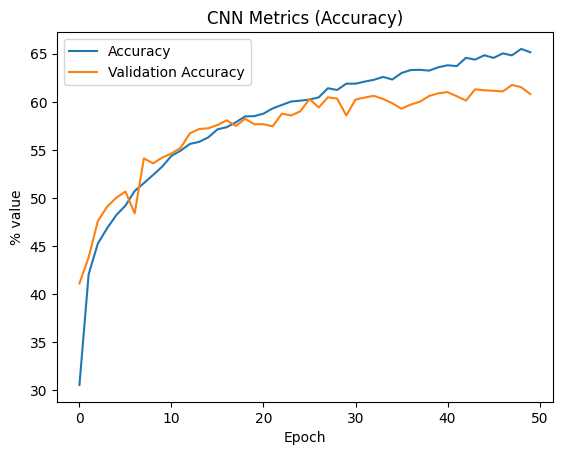

In [9]:
# Plot training and validation accuracy
plt.plot(train_accuracies, label='Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

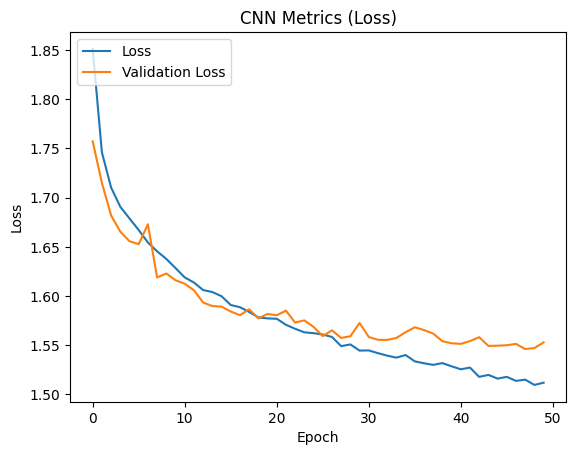

In [10]:
# Plot training and validation loss
plt.plot(train_losses, label='Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('CNN Metrics (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [11]:
# Sauvegarder le modèle entraîné
torch.save(model.state_dict(), "cnn_emotion.pth")
print("Modèle sauvegardé sous cnn_emotion.pth")

Modèle sauvegardé sous cnn_emotion.pth


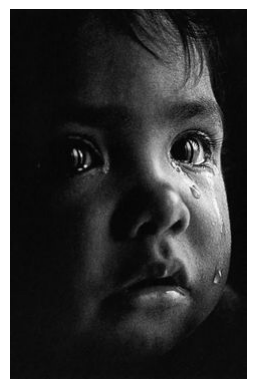

Émotion prédite : Tristesse


In [26]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir en niveaux de gris si nécessaire
    transforms.Resize((48, 48)),  # Redimensionner comme les images du dataset
    transforms.ToTensor(),  # Convertir en tenseur PyTorch
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation (ajuste selon ton dataset)
])
# Charger l'image
image_path = "000.jpg"  # Remplace par ton chemin d'image
image = Image.open(image_path)

# Afficher l'image originale
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

# Appliquer les transformations
input_image = transform(image).unsqueeze(0)  # Ajouter une dimension batch
# Faire la prédiction
with torch.no_grad():
    output = model(input_image)
    predicted_class = torch.argmax(output, dim=1).item()

# Afficher la prédiction
classes = ["Colère", "Dégoût", "Peur", "Joie", "Neutre", "Tristesse", "Surprise"]  # Adapte selon tes classes
print(f"Émotion prédite : {classes[predicted_class]}")
